In [1]:
import os
import gc
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import seaborn as sns

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.utils.data as data
from PIL import Image
import torch.nn.functional as F

/home/victor/codes/python_env/virtualenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/victor/codes/python_env/virtualenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"GPU is available with {num_gpus} device(s).")
    
    # Get the name of the current GPU
    current_gpu = torch.cuda.get_device_name(0)  # Assuming the first GPU is used
    print(f"Current GPU: {current_gpu}")
else:
    print("GPU is not available. Using CPU.")

GPU is available with 1 device(s).
Current GPU: NVIDIA GeForce GTX 1660


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the first available GPU
else:
    device = torch.device("cpu")  # If no GPU is available, use CPU

In [4]:
current_directory = os.getcwd()
models_dir = current_directory + '/models'
os.makedirs(models_dir, exist_ok=True)
df = pd.read_csv('filtered_data.csv')
images_dir = '/run/media/victor/victor/cv_project/SolarPanelSoilingImageDataset/Solar_Panel_Soiling_Image_dataset/PanelImages'

In [5]:
train_df, test_df = train_test_split(df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

In [1]:
class SolarPanelDataset(data.Dataset):
    #data_dir: The directory containing the image files
    #image_shape: The shape of the images (height, width, channels)
    #augmentation_copies: The number of copies of each image to create for data augmentation
    def __init__(self, df, data_dir, image_shape=(3, 192, 192), augmentation_copies=1):
        self.copies = 1 + augmentation_copies
        self.image_shape = image_shape
        self.df = df #df: A pandas DataFrame containing the image filenames and labels
        self.labels = []
        self.transform = transforms.Compose([
            transforms.Resize((self.image_shape[1], self.image_shape[2])),
            transforms.ToTensor(),
        ])

        self.augmentation_transform = self.make_augmentation_transform()
        self.dataset_size = len(df)
        self.images = torch.zeros((self.dataset_size, *self.image_shape), dtype=torch.float32)

        for i, img_name in enumerate(self.df['original_title']):
            img_path = os.path.join(data_dir, img_name)
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            self.images[i] = image
            label = df.iloc[i]['loss_percentage']
            self.labels.append(label)  # Add corresponding label here

    def __len__(self):
        return len(self.images)*self.copies

    def make_augmentation_transform(self):
        return transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.2),
            transforms.RandomVerticalFlip(p=0.2),
            transforms.RandomRotation(degrees=20),
            transforms.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1)),
            transforms.GaussianBlur(kernel_size=3),  # You can adjust the kernel size
            transforms.RandomApply([transforms.Lambda(lambda x: x + 0.01 * torch.randn_like(x))], p=0.2),
        ])

    def __getitem__(self, idx):
        if (idx >= len(self.images) ):
            image = self.images[idx % len(self.images)]
            label = self.labels[idx % len(self.labels)]
            return self.augmentation_transform(image), torch.tensor(label, dtype=torch.float32)


        image = self.images[idx]
        label = self.labels[idx]
        return image, torch.tensor(label, dtype=torch.float32)

NameError: name 'Dataset' is not defined

In [7]:
class Regression_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(32400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [8]:
class CNN_2(nn.Module):
    def __init__(self):
        super(CNN_2, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # Batch normalization for improved training stability
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(256)

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 24 * 24, 512)
        self.fc2 = nn.Linear(512, 1)
        self.sigmoid_layer = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.batch_norm2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.batch_norm3(self.conv3(x))))

        x = x.view(-1, 256 * 24 * 24)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid_layer(x)

        return x

In [9]:

# Function to save the model
def saveModel(model:nn.Module, path):
    torch.save(model.state_dict(), path)

# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          valloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          metric: torchmetrics.Metric,
          device: torch.device,
          num_epochs,
          path_model,
          report: pd.DataFrame,
          verbatim):
    model.to(device)
    metric.to(device)
    best_accuracy = 0.0
    best_loss = 0.0
    best_epoch = 0
    metric_algorithm = metric.__class__.__name__
    loss_algorithm = loss_fn.__class__.__name__
    best_metric = 100
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        model.train()
        metric.reset()
        train_acc = 0.0
        train_loss = 0.0
        for ibatch, (images, labels) in enumerate(dataloader, 0):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            y_pred = model(images)
            y_pred = y_pred.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
            loss = loss_fn(y_pred, labels)
            train_loss += loss.item()

            metric(y_pred, labels)
            loss.backward()
            optimizer.step()

            # Calculate and accumulate accuracy metric across all batches
            #y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            #train_acc += (y_pred_class == labels).sum().item()/len(y_pred)

        # Adjust metrics to get average loss and accuracy per batch
        train_loss = train_loss / len(dataloader)

        # we want to save the model if the accuracy is the best

        path = "./myModel_" +str(epoch)+ ".pth"
        #saveModel(model, path = path)

        train_metric = metric.compute().item()/len(dataloader)
        report_line = {'epoch': epoch,
                       'loss': train_loss,
                       'metric_algorithm': metric_algorithm,
                       'metric': train_metric,
                       'loss_algorithm': loss_algorithm,
                       'mode': 'training'
                      }
        report = pd.concat([report, pd.DataFrame([report_line])], ignore_index=True)

        if train_metric < best_metric:
            path = str(path_model + '/bestModel.pth')
            saveModel(model, path = path)
            best_loss = train_loss
            best_metric = train_metric
            best_epoch = epoch
            if verbatim:
              print('Best Epoch #', epoch,' Loss=', best_loss, " mean MAE(%)=", train_metric)
                
        model.eval()
        metric.reset()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in valloader:
                images = images.to(device)
                labels = labels.to(device)
                y_pred = model(images)
                y_pred = y_pred.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
                val_loss += loss_fn(y_pred, labels).item()
                metric(y_pred, labels)
    
        val_loss /= len(valloader)
        val_metric = metric.compute().item()/len(valloader)
        report_line = {'epoch': epoch,
                       'loss': val_loss,
                       'metric_algorithm': metric_algorithm,
                       'metric': val_metric,
                       'loss_algorithm': loss_algorithm,
                       'mode': 'validation'
                      }

        print(val_metric)
        report = pd.concat([report, pd.DataFrame([report_line])], ignore_index=True)
    return best_loss, best_accuracy, best_epoch, report

In [48]:
model = None
gc.collect() # Python thing

model = CNN_2()
metric = torchmetrics.MeanAbsolutePercentageError()
train_dataset = SolarPanelDataset(train_df.sample(2000), images_dir)
val_dataset = SolarPanelDataset(val_df.sample(400), images_dir)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
loss_fn = torch.nn.MSELoss().to(device)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 10
path_model = models_dir + f'/{model.__class__.__name__}_{loss_fn.__class__.__name__}'
os.makedirs(path_model, exist_ok=True)
report = pd.DataFrame()
_, _, _, report = train(model, train_dataloader, val_dataloader, loss_fn, optimizer, metric, device, num_epochs, path_model, report, verbatim=True)

Best Epoch # 0  Loss= 0.13654504550827873  mean MAE(%)= 0.018595192167494033
0.07692307692307693
Best Epoch # 1  Loss= 0.1354757525499851  mean MAE(%)= 0.01586507899420602
0.07692307692307693
0.07692307692307693
0.07692307692307693
0.07692307692307693
0.07692307692307693
0.07692307692307693
0.07692307692307693
0.07692307692307693
0.07692307692307693


<AxesSubplot:xlabel='epoch', ylabel='metric'>

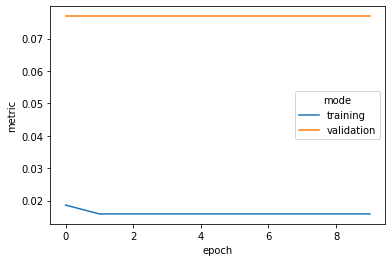

In [49]:
sns.lineplot(data=report, x='epoch', y='metric', hue='mode')

In [50]:
# Function to test the model with the test dataset and print the accuracy for the test images
def test(model: torch.nn.Module,
         dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         metric: torchmetrics.Metric,
         device: torch.device,
         verbatim = True):

    model.eval()
    model.to(device)
    metric = metric.to(device)

    # Setup test loss and test accuracy values
    test_loss = 0
    test_metric = 100
    pred_labels = []
    label_list = []
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            y_pred = model(images)
            y_pred = y_pred.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
            pred_labels+=y_pred.tolist()
            label_list += labels.tolist()
            
            loss = loss_fn(y_pred, labels)
            test_loss += loss.item()
            metric.update(y_pred, labels)

    eval_df = pd.DataFrame({'labels': label_list, 'predictions': pred_labels})
    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_metric = metric.compute()

    if verbatim:
      print("Loss =", test_loss, f'  Metric ({metric.__class__.__name__})=', test_metric.item())
    return pred_labels, test_loss, test_metric, eval_df

In [51]:
metric = torchmetrics.MeanAbsolutePercentageError()
test_dataset = SolarPanelDataset(test_df.sample(200), images_dir, augmentation_copies=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
_, _, _, eval_df = test(model, test_dataloader, loss_fn, metric, device, verbatim=True)

Loss = 0.1320844143629074   Metric (MeanAbsolutePercentageError)= 1.0


In [52]:
eval_df

,labels,predictions
0,0.672452,0.0
1,0.395786,0.0
2,0.018813,0.0
3,0.595761,0.0
4,0.017543,0.0
...,...,...
195,0.754628,0.0
196,0.051934,0.0
197,0.013678,0.0
198,0.037478,0.0


In [53]:
eval_df['diff'] = eval_df['labels'] - eval_df['predictions']
eval_df['diff'] = eval_df['diff'].abs()


<AxesSubplot:ylabel='Frequency'>

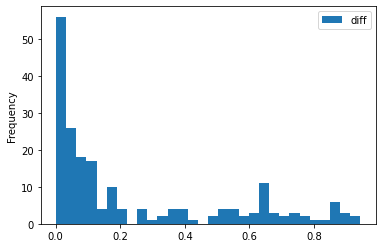

In [54]:
eval_df.plot(kind='hist', y='diff', bins=30)